In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns

In [5]:
#Importation des biblio
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve,precision_recall_curve, classification_report, auc,accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn import metrics

In [6]:
#Importation des donnees
df = pd.read_csv('Data/diabetesPima.csv')


In [7]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

In [8]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [9]:
def median_column(var):   
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [10]:
columns = df.columns
columns = columns.drop("Outcome")
for i in columns:
    median_column(i)
    df.loc[(df['Outcome'] == 0 ) & (df[i].isnull()), i] = median_column(i)[i][0]
    df.loc[(df['Outcome'] == 1 ) & (df[i].isnull()), i] = median_column(i)[i][1]

In [11]:
from sklearn import preprocessing
from sklearn import compose
from sklearn import impute
X=df.drop('Outcome',axis=1)
Y=df['Outcome']
scaler=preprocessing.RobustScaler()
scaled=scaler.fit_transform(X)

In [12]:
#Separation des donnes en 80% pour l entrainement et 20% pour test
X_train, X_test, y_train, y_test = train_test_split(scaled, Y, test_size=0.2,
                                                    random_state=42)

In [13]:
#Créer le modèle Randomforest
# Définir les hyperparamètres à tester pour Random Forest
param_grid = {
'n_estimators': [50, 100, 200],
'max_depth': [4,6,None],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4],
}
# Créer le modèle Random Forest
modelRDF = RandomForestClassifier(random_state=42)
# Utiliser GridSearchCV pour le réglage des hyperparamètres
grid_searchRDF = GridSearchCV(estimator=modelRDF, param_grid=param_grid, cv=5,
                           scoring='accuracy',verbose=2)

In [14]:
grid_searchRDF.fit(scaled, Y)
# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres : ", grid_searchRDF.best_params_)
# Utiliser les meilleurs hyperparamètres pour créer le modèle final
best_modelRDF = grid_searchRDF.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=4, min_samples_leaf=1, m

In [15]:
cv = StratifiedKFold(n_splits=5)
# Effectuer la validation croisée
cv_scores = cross_val_score(best_modelRDF, scaled, Y, cv=cv, scoring='accuracy')
# Entraîner le modèle sur l'ensemble d'entraînement
best_modelRDF.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [16]:
# Prédire sur l'ensemble de test
y_pred_test = best_modelRDF.predict(X_test)
y_pred_train = best_modelRDF.predict(X_train)

#Prediction des probabiliter
y_pred_proba_test = best_modelRDF.predict_proba(X_test)[:,1]
y_pred_proba_train = best_modelRDF.predict_proba(X_train)[:,1]

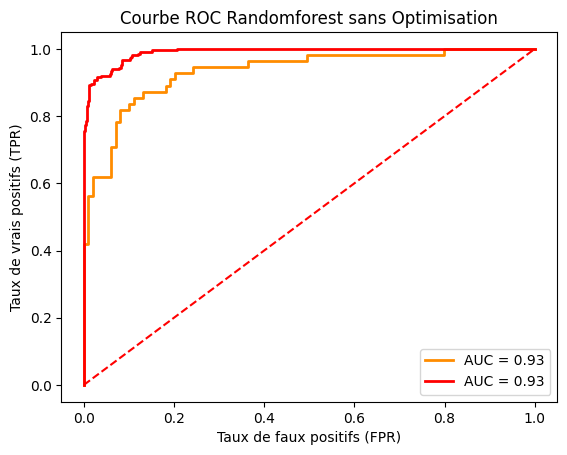

In [17]:
#Courbe ROC
fpr_test,tpr_test,_=roc_curve(y_test,y_pred_proba_test)
roc_auc_test=auc(fpr_test,tpr_test)

fpr_train,tpr_train,_=roc_curve(y_train,y_pred_proba_train)
roc_auc_train=auc(fpr_test,tpr_test)

plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'AUC = {roc_auc_test:.2f}')
plt.plot(fpr_train, tpr_train, color='red', lw=2, label=f'AUC = {roc_auc_train:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend()
plt.title('Courbe ROC Randomforest sans Optimisation')
plt.show()

In [18]:
# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred_test)
accuarncy_train=metrics.accuracy_score(y_train, y_pred_train)
preceision=precision_score(y_test, y_pred_test)
recall=recall_score(y_test, y_pred_test)
f1_score=metrics.f1_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

In [19]:
# Afficher les résultats
print(f"Scores de validation croisée : {cv_scores}")
print(f"Précision moyenne de la validation croisée : {cv_scores.mean()*100:.2f}%")
print(f"Précision globale sur l'ensemble de test : {accuracy * 100:.2f}%")
print("Rapport de classification :")
print(report)
metrics_rf = {
    'Algorithme': 'Randomforest',
    'Accuracy': round(accuracy*100,2),
    'Accuracy train': round(accuarncy_train*100,2),
    'Precision': round(preceision*100,2),
    'Recall': round(recall*100,2),
    'F1-Score': round(f1_score*100,2),
    'Validation croise': round(cv_scores.mean()*100,2),
    'AUC':roc_auc_test
}
metrics_rf

Scores de validation croisée : [0.88311688 0.86363636 0.87012987 0.91503268 0.90196078]
Précision moyenne de la validation croisée : 88.68%
Précision globale sur l'ensemble de test : 87.01%
Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        99
           1       0.80      0.85      0.82        55

    accuracy                           0.87       154
   macro avg       0.86      0.87      0.86       154
weighted avg       0.87      0.87      0.87       154



{'Algorithme': 'Randomforest',
 'Accuracy': 87.01,
 'Accuracy train': 94.95,
 'Precision': 79.66,
 'Recall': 85.45,
 'F1-Score': 82.46,
 'Validation croise': np.float64(88.68),
 'AUC': np.float64(0.9325987144168962)}

In [20]:
print(conf_matrix)

[[87 12]
 [ 8 47]]


In [22]:
df1=pd.read_csv('Data/diabetesFRLEARN.csv')

In [23]:
df1[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = \
df1[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)

In [24]:
def median_column(var):   
    temp = df1[df1[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [25]:
columns = df1.columns
columns = columns.drop("Outcome")
for i in columns:
    median_column(i)
    df1.loc[(df1['Outcome'] == 0 ) & (df1[i].isnull()), i] = median_column(i)[i][0]
    df1.loc[(df1['Outcome'] == 1 ) & (df1[i].isnull()), i] = median_column(i)[i][1]

In [26]:
from sklearn import preprocessing
from sklearn import compose
from sklearn import impute
X1=df1.drop('Outcome',axis=1)
Y1=df1['Outcome']
scaler1=preprocessing.RobustScaler()
scaled1=scaler1.fit_transform(X1)

In [27]:
#Separation des donnes en 80% pour l entrainement et 20% pour test
X_train1, X_test1, y_train1, y_test1 = train_test_split(scaled1, Y1, test_size=0.2,
                                                    random_state=42)

In [28]:
cv = StratifiedKFold(n_splits=5)
# Effectuer la validation croisée
cv_scores = cross_val_score(best_modelRDF, scaled1, Y1, cv=cv, scoring='accuracy')
# Entraîner le modèle sur l'ensemble d'entraînement
best_modelRDF.fit(X_train1, y_train1)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

In [29]:
# Prédire sur l'ensemble de test
y_pred_test1 = best_modelRDF.predict(X_test1)
y_pred_train1 = best_modelRDF.predict(X_train1)

#Prediction des probabiliter
y_pred_proba_test1 = best_modelRDF.predict_proba(X_test1)[:,1]
y_pred_proba_train1 = best_modelRDF.predict_proba(X_train1)[:,1]

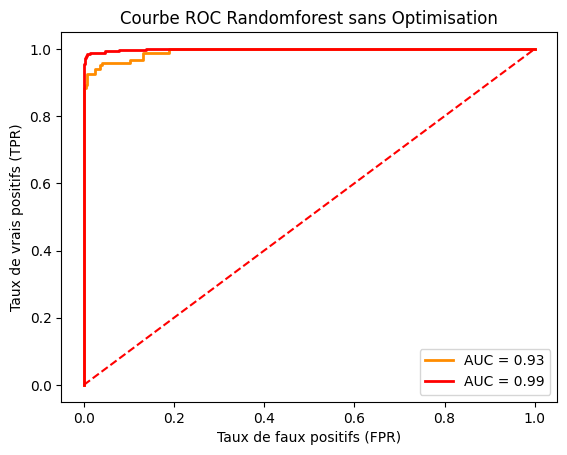

In [30]:
#Courbe ROC
fpr_test1,tpr_test1,_=roc_curve(y_test1,y_pred_proba_test1)
roc_auc_test1=auc(fpr_test,tpr_test)

fpr_train1,tpr_train1,_=roc_curve(y_train1,y_pred_proba_train1)
roc_auc_train1=auc(fpr_test1,tpr_test1)

plt.figure()
plt.plot(fpr_test1, tpr_test1, color='darkorange', lw=2, label=f'AUC = {roc_auc_test1:.2f}')
plt.plot(fpr_train1, tpr_train1, color='red', lw=2, label=f'AUC = {roc_auc_train1:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend()
plt.title('Courbe ROC Randomforest sans Optimisation')
plt.show()

In [31]:
# Évaluer le modèle
accuracy1 = accuracy_score(y_test1, y_pred_test1)
accuarncy_train1=metrics.accuracy_score(y_train1, y_pred_train1)
preceision1=precision_score(y_test1, y_pred_test1)
recall1=recall_score(y_test1, y_pred_test1)
f1_score1=metrics.f1_score(y_test1, y_pred_test1)
report1 = classification_report(y_test1, y_pred_test1)
conf_matrix1 = confusion_matrix(y_test1, y_pred_test1)

In [32]:
# Afficher les résultats
print(f"Scores de validation croisée : {cv_scores}")
print(f"Précision moyenne de la validation croisée : {cv_scores.mean()*100:.2f}%")
print(f"Précision globale sur l'ensemble de test : {accuracy1 * 100:.2f}%")
print("Rapport de classification :")
print(report1)
metrics_rf1 = {
    'Algorithme': 'Randomforest',
    'Accuracy': round(accuracy1*100,2),
    'Accuracy train': round(accuarncy_train1*100,2),
    'Precision': round(preceision1*100,2),
    'Recall': round(recall1*100,2),
    'F1-Score': round(f1_score1*100,2),
    'Validation croise': round(cv_scores.mean()*100,2),
    'AUC':roc_auc_test1
}
metrics_rf1

Scores de validation croisée : [0.9525 0.98   0.9825 0.93   0.975 ]
Précision moyenne de la validation croisée : 96.40%
Précision globale sur l'ensemble de test : 96.00%
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       253
           1       0.96      0.93      0.94       147

    accuracy                           0.96       400
   macro avg       0.96      0.95      0.96       400
weighted avg       0.96      0.96      0.96       400



{'Algorithme': 'Randomforest',
 'Accuracy': 96.0,
 'Accuracy train': 99.0,
 'Precision': 95.8,
 'Recall': 93.2,
 'F1-Score': 94.48,
 'Validation croise': np.float64(96.4),
 'AUC': np.float64(0.9325987144168962)}

## Enregitrement des models et scaler

In [33]:
import pickle

In [34]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler1, f)

In [36]:
with open("Randomforest.pkl", "wb") as f:
    pickle.dump(best_modelRDF, f)